In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

import optuna

### Load the train and test data

In [2]:
df_train = pd.read_csv('../input/30-days-of-ml/train.csv',index_col=0)
df_test = pd.read_csv('../input/30-days-of-ml/test.csv',index_col=0)

### Data overview

In [3]:
df_train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
id,,,,,,,,,,,,,,,,,,,,,
1,B,B,B,C,B,B,A,E,C,N,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
2,B,B,A,A,B,D,A,F,A,O,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
3,A,A,A,C,B,D,A,D,A,F,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
4,B,B,A,C,B,D,A,E,C,K,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
6,A,A,A,C,B,D,A,E,A,N,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 1 to 499999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  object 
 1   cat1    300000 non-null  object 
 2   cat2    300000 non-null  object 
 3   cat3    300000 non-null  object 
 4   cat4    300000 non-null  object 
 5   cat5    300000 non-null  object 
 6   cat6    300000 non-null  object 
 7   cat7    300000 non-null  object 
 8   cat8    300000 non-null  object 
 9   cat9    300000 non-null  object 
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

**-> The dataset consists of numerical and categorical features without any missing values.**

In [5]:
# Generating X and y

X_train = df_train.drop('target', axis=1)
y_train = df_train.target

X_test = df_test.copy()

### Encoding Cat features

In [6]:
# Separating Categorical and Numerical features
cat_col = X_train.select_dtypes(include='object').columns
num_col = X_train.select_dtypes(include='float64').columns

# Ordinal-Encoding for Categorical variables
encoder = OrdinalEncoder()
X_train[cat_col] = encoder.fit_transform(X_train[cat_col])
X_test[cat_col] = encoder.transform(X_test[cat_col])

### Target prediction using XGBoost

In [7]:
# Splitting parameters
n_splits = 5
kf = KFold(n_splits, shuffle=True, random_state=0)


# Generating and Modeling for each fold
pred_test=0
for fold, (train_indx, valid_indx) in enumerate(kf.split(X_train)):
    
    # Preparing X and y for regressor
    X_train_fold = X_train.iloc[train_indx]
    y_train_fold = y_train.iloc[train_indx]
    
    X_valid_fold = X_train.iloc[valid_indx]
    y_valid_fold = y_train.iloc[valid_indx]
    
    # Modeling using XGBoost
    model=XGBRegressor(tree_method = 'gpu_hist')
    model.fit(X_train_fold, y_train_fold,verbose=False)
    
    # Predicting & reporting targets for validation folds
    pred_valid_fold = model.predict(X_valid_fold)
    RMSE_fold = mean_squared_error(pred_valid_fold, y_valid_fold, squared=False)  
    print(f'Fold {fold}: {RMSE_fold:.5f}')
    
    # Predicting targets for test dataset:
    pred_test_fold = model.predict(X_test)
    pred_test += pred_test_fold/n_splits

Fold 0: 0.72671
Fold 1: 0.72438
Fold 2: 0.72902
Fold 3: 0.72271
Fold 4: 0.72364


<AxesSubplot:>

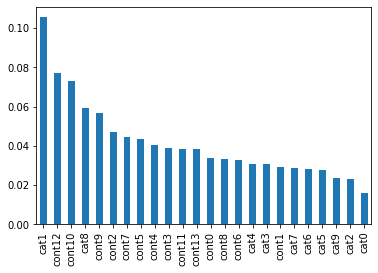

In [8]:
# Feature Importance
pd.Series(data=model.feature_importances_,
         index=X_train.columns).sort_values(ascending=False).plot.bar()

In [9]:
# Save the predictions to a CSV file
output = pd.DataFrame({'Id': X_test.index,
                       'target': pred_test})
output.to_csv('submission.csv', index=False)